In [ ]:
!pip install tsai --quiet
!pip install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.1/313.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.8 MB/s eta 0:00:00


In [ ]:
from tsai.all import *

# Rede Inception

In [ ]:
# Helper to shortcut for residual blocks, don't do anything
def noop(x: torch.Tensor) -> torch.Tensor:
    return x

# class ReLU(nn.Module):
#     """ ReLU Activation Function
#     """
#     def __init__(self):
#         super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return nn.functional.relu(x)

class InceptionModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: Tuple[int, int, int] = [7, 5, 3], bottleneck: bool = True) -> None:
        """ Inception Module to apply parallel convolution on time series.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (Tuple[int, int, int], optional): Number of kernels. Defaults to [7, 5, 3].
            bottleneck (bool, optional): If apply a bottleneck layer to convert the number of channels to the correct shape. Defaults to True.
        """
        super().__init__()

        self.kernel_sizes = kernel_size
        # Only apply bottleneck if the input channels number is bigger than 1
        bottleneck = bottleneck if in_channels > 1 else False
        self.bottleneck = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False, padding='same') if bottleneck else noop
        # Calculate and apply convolutions for each kernel size
        self.convolutions = nn.ModuleList([
            nn.Conv1d(out_channels if bottleneck else in_channels, out_channels, kernel_size=k, padding='same', bias=False) for k in self.kernel_sizes
        ])
        # Max Convolutional Pooling layer
        self.maxconv = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), nn.Conv1d(in_channels, out_channels, 1, bias=False, padding='same')])
        self.batchnorm = nn.BatchNorm1d(out_channels * 4)
        self.activation = ReLU() # We just have to modify this activation between ReLU and LeakySineLU

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print('foward-M', x.shape)
        x_ = x
        x = self.bottleneck(x)
        # Conv1, Conv2, Conv3, MaxConv
        x = torch.cat([conv(x) for conv in self.convolutions] + [self.maxconv(x_)], dim=1)
        return self.activation(x)


class InceptionBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, residual: bool = True, depth: int = 6) -> None:
        super().__init__()
        self.residual = residual
        self.depth = depth

        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            # Build each inception module
            self.inception.append(InceptionModule(
                in_channels=(in_channels if d == 0 else out_channels * 4), out_channels=out_channels,
            ))
            if self.residual and d % 3 == 2:
                c_in, c_out = in_channels if d == 2 else out_channels * 4, out_channels * 4
                self.shortcut.append(
                    nn.BatchNorm1d(c_in) if c_in == c_out else nn.Sequential(*[nn.Conv1d(c_in, c_out, kernel_size=1, padding='same'), nn.BatchNorm1d(c_out)])
                )
        self.activation = ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print('foward-b', x.shape)
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2:
               res = x = self.activation(x + self.shortcut[d // 3](res))
        return x


class InceptionTime(nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, sequence_len: int, class_num: int) -> None:
        super().__init__()
        self.inception_block = InceptionBlock(in_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels * 4, class_num)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print('foward-Icpt', x.shape)
        x = self.inception_block(x)
        x = torch.mean(x, dim=-1)
        return self.relu(self.fc(x))

# Datasets disponiveis

In [ ]:
# Datasets disponiveis no TSER
reg_list = get_Monash_regression_list() # Funcao do TSAI para pegar dados do TSER
reg_list

['AppliancesEnergy',
 'AustraliaRainfall',
 'BeijingPM10Quality',
 'BeijingPM25Quality',
 'BenzeneConcentration',
 'Covid3Month',
 'FloodModeling1',
 'FloodModeling2',
 'FloodModeling3',
 'HouseholdPowerConsumption1',
 'HouseholdPowerConsumption2',
 'IEEEPPG',
 'LiveFuelMoistureContent',
 'NewsHeadlineSentiment',
 'NewsTitleSentiment']

# Datasets ja usados

In [ ]:
# Datasets já analisados
finished_list = ['FloodModeling1', 'Covid3Month', 'AustraliaRainfall'] # Datasets já analisados
print(dls.vars, 32, dls.len, dls.c) # Variaveis, batch size, tamanho e classes

1 32 266 1


# Treinando a rede

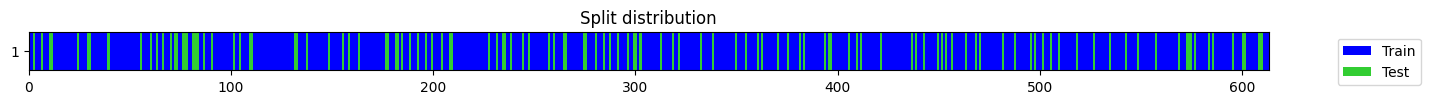

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.067226,0.054069,0.223890,0.232528,00:05
1,0.066002,0.050105,0.208436,0.223842,00:06
2,0.065326,0.049878,0.197842,0.223334,00:04
3,0.064452,0.050667,0.189886,0.225094,00:05
4,0.063752,0.050344,0.183392,0.224374,00:05
5,0.062875,0.051310,0.186085,0.226517,00:05
6,0.061911,0.052346,0.188558,0.228793,00:05
7,0.061114,0.052398,0.190348,0.228905,00:04
8,0.060149,0.051696,0.190073,0.227368,00:06
9,0.059176,0.050209,0.187641,0.224074,00:04


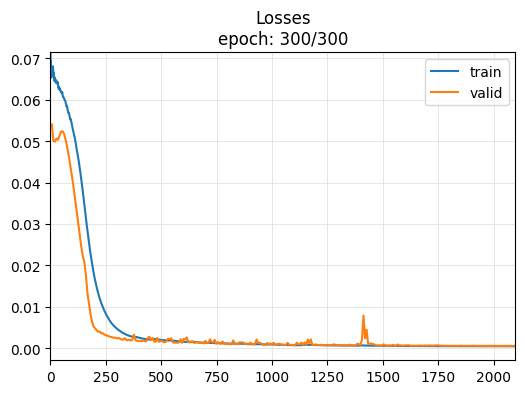

,train_loss,valid_loss,mae,_rmse
299,0.00049,0.000583,0.017667,0.024148


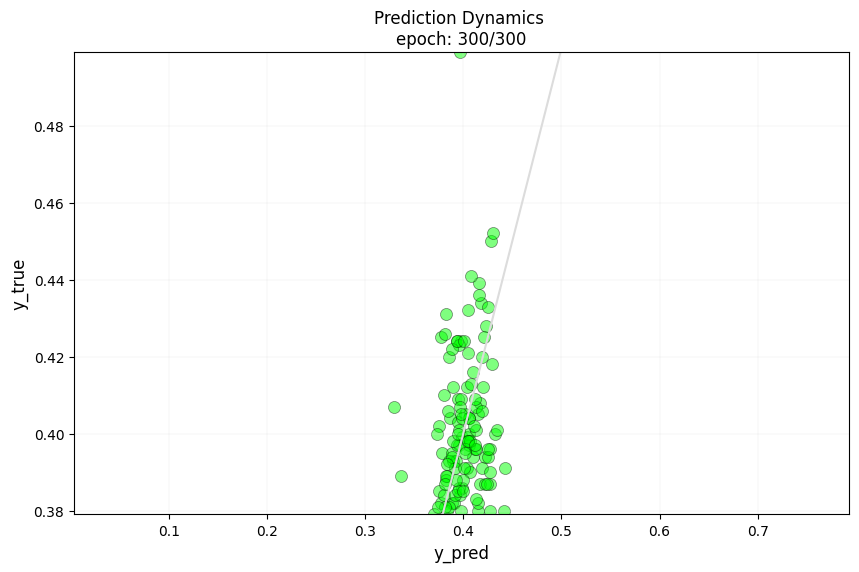

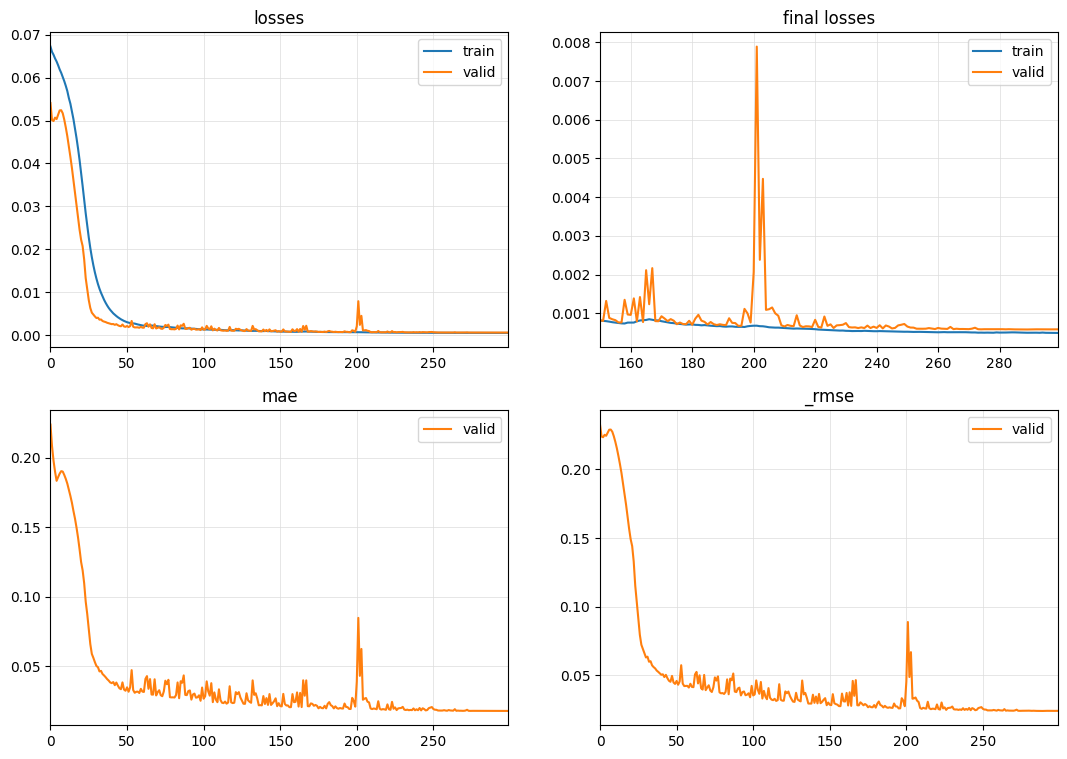

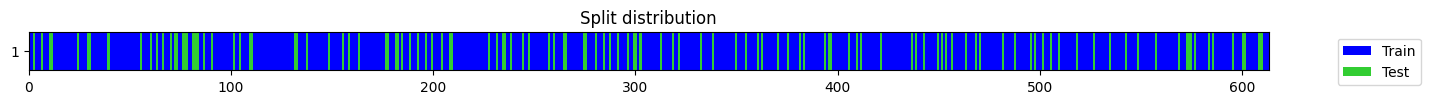

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.161885,0.162042,0.402115,0.402544,00:06
1,0.161915,0.162042,0.402115,0.402544,00:04
2,0.161885,0.162042,0.402115,0.402544,00:05
3,0.161916,0.162042,0.402115,0.402544,00:04
4,0.162003,0.162042,0.402115,0.402544,00:05
5,0.162066,0.162042,0.402115,0.402544,00:05
6,0.162031,0.162042,0.402115,0.402544,00:04
7,0.162023,0.162042,0.402115,0.402544,00:05
8,0.162071,0.162042,0.402115,0.402544,00:04
9,0.162067,0.162042,0.402115,0.402544,00:06


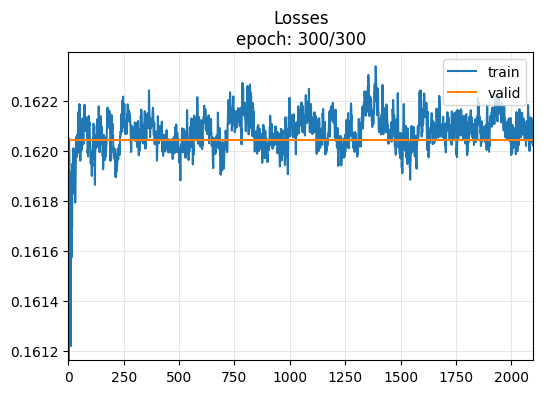

,train_loss,valid_loss,mae,_rmse
299,0.162104,0.162042,0.402115,0.402544


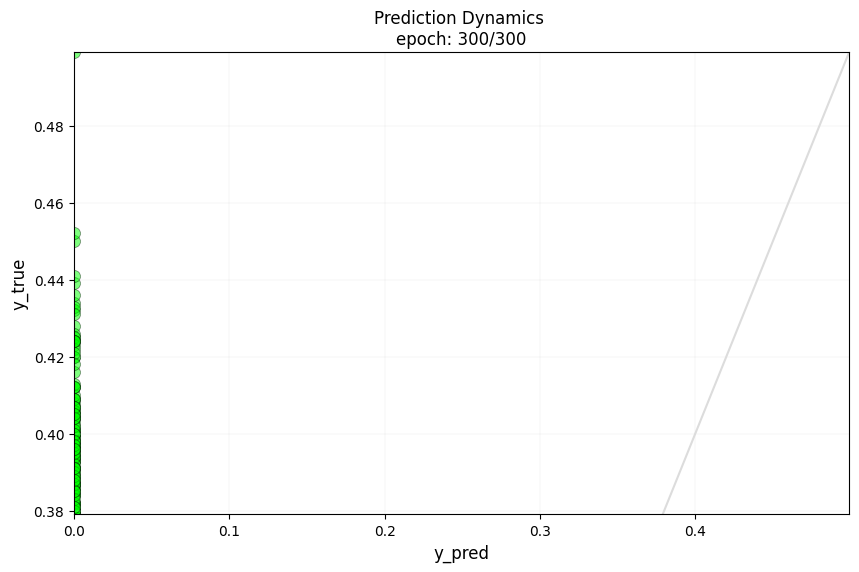

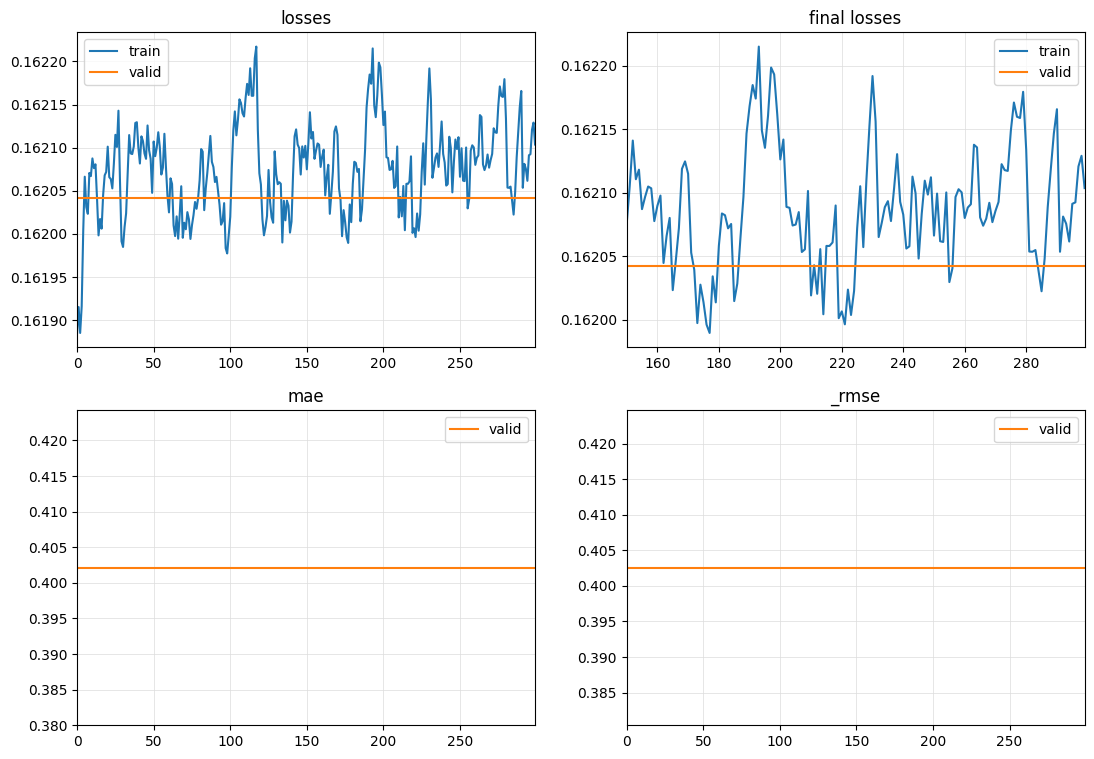

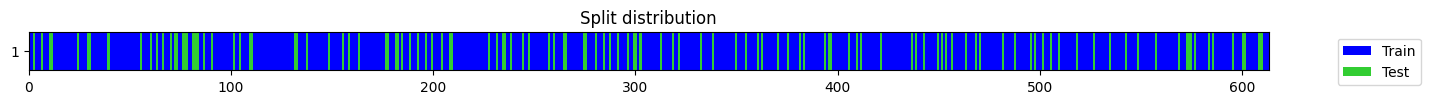

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.161955,0.162042,0.402115,0.402544,00:04
1,0.161973,0.162042,0.402115,0.402544,00:05
2,0.161812,0.162042,0.402115,0.402544,00:05
3,0.161987,0.162042,0.402115,0.402544,00:06
4,0.161919,0.162042,0.402115,0.402544,00:05
5,0.161975,0.162042,0.402115,0.402544,00:05
6,0.162006,0.162042,0.402115,0.402544,00:05
7,0.161999,0.162042,0.402115,0.402544,00:06
8,0.162017,0.162042,0.402115,0.402544,00:05
9,0.161999,0.162042,0.402115,0.402544,00:05


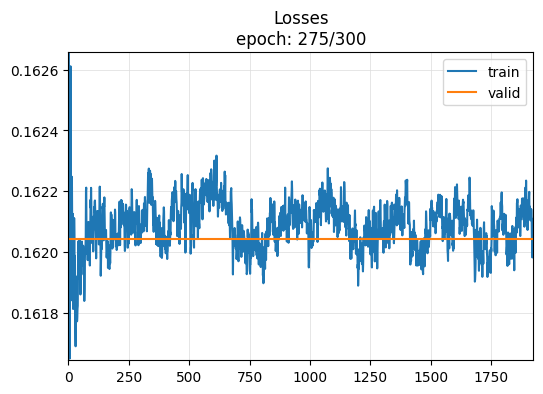

,train_loss,valid_loss,mae,_rmse
274,0.162108,0.162042,0.402115,0.402544


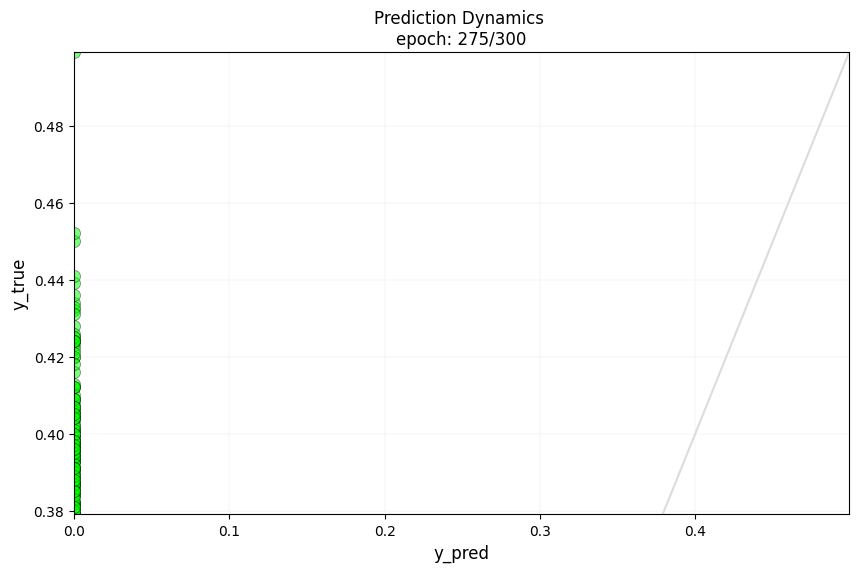

In [ ]:
# for data in reg_list:
#  if data in finished_list:
#    continue
  X, y, splits = get_Monash_regression_data(data, split_data=False) # Testando todos datasets
  for i in range(5): # Repetindo o experimento 5x para cada Dataset da lista
    tfms=[None, TSRegression()]
    batch_tfms = TSStandardize(by_sample=True, by_var=True) # Padronizando
    splits = get_splits(y, valid_size=.2, stratify=True, random_state=42, shuffle=True) # Data split igual para todos
    dls = get_ts_dls(X,y,splits=splits,tfms=tfms, batch_tfms=batch_tfms) # Dataloaders
    model = InceptionTime(dls.vars, 32, dls.len, dls.c) # Rede Neural
    learn = ts_learner(dls, model, metrics=[mae, rmse], cbs=[ShowGraph(), PredictionDynamics(alpha=.5, size=75)]) # Learner: usar MAE e RMSE, com grafico de loss e grafico Y_true Y_pred
    learn.fit_one_cycle(300, 3e-4) # 300 epocas e lr de 3e-4
    learn.save_all(path=f'ReLU_{data}_{i}', dls_fname='dls', model_fname='InceptionTime', learner_fname='learner') # Salvando o modelo

# Salvando os modelos em um .zip

In [ ]:
# from google.colab import files

# !zip -r ReLU_FloodModeling1_4.zip ReLU_FloodModeling1_4
# for i in range(5):
#   files.download(f'ReLU_FloodModeling1_{i}.zip')